<a href="https://colab.research.google.com/github/Rangarana/ai_diffusers/blob/main/diffusers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import requests
from tqdm import tqdm
from diffusers import DDPMScheduler


def make_1step_sched():
    noise_scheduler_1step = DDPMScheduler.from_pretrained("stabilityai/sd-turbo", subfolder="scheduler")
    noise_scheduler_1step.set_timesteps(1, device="cuda")
    noise_scheduler_1step.alphas_cumprod = noise_scheduler_1step.alphas_cumprod.cuda()
    return noise_scheduler_1step


def my_vae_encoder_fwd(self, sample):
    sample = self.conv_in(sample)
    l_blocks = []
    # down
    for down_block in self.down_blocks:
        l_blocks.append(sample)
        sample = down_block(sample)
    # middle
    sample = self.mid_block(sample)
    sample = self.conv_norm_out(sample)
    sample = self.conv_act(sample)
    sample = self.conv_out(sample)
    self.current_down_blocks = l_blocks
    return sample


def my_vae_decoder_fwd(self, sample, latent_embeds=None):
    sample = self.conv_in(sample)
    upscale_dtype = next(iter(self.up_blocks.parameters())).dtype
    # middle
    sample = self.mid_block(sample, latent_embeds)
    sample = sample.to(upscale_dtype)
    if not self.ignore_skip:
        skip_convs = [self.skip_conv_1, self.skip_conv_2, self.skip_conv_3, self.skip_conv_4]
        # up
        for idx, up_block in enumerate(self.up_blocks):
            skip_in = skip_convs[idx](self.incoming_skip_acts[::-1][idx] * self.gamma)
            # add skip
            sample = sample + skip_in
            sample = up_block(sample, latent_embeds)
    else:
        for idx, up_block in enumerate(self.up_blocks):
            sample = up_block(sample, latent_embeds)
    # post-process
    if latent_embeds is None:
        sample = self.conv_norm_out(sample)
    else:
        sample = self.conv_norm_out(sample, latent_embeds)
    sample = self.conv_act(sample)
    sample = self.conv_out(sample)
    return sample


def download_url(url, outf):
    if not os.path.exists(outf):
        print(f"Downloading checkpoint to {outf}")
        response = requests.get(url, stream=True)
        total_size_in_bytes = int(response.headers.get('content-length', 0))
        block_size = 1024  # 1 Kibibyte
        progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
        with open(outf, 'wb') as file:
            for data in response.iter_content(block_size):
                progress_bar.update(len(data))
                file.write(data)
        progress_bar.close()
        if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
            print("ERROR, something went wrong")
        print(f"Downloaded successfully to {outf}")
    else:
        print(f"Skipping download, {outf} already exists")

In [ ]:
def annotation_to_mask(image, annotation):
   """Converts annotation to binary mask and saves it to disk.


   Args:
       image (np.array): Image to be masked.
       annotation (list):
           Annotation coordinates in the form of [x1, y1, x2, y2, ...].
   """
   annotation = np.array([(int(x), int(y))
                          for x, y in zip(*[iter(annotation)] * 2)])
   mask = np.ones(image.shape[:2], np.float32) * 255
   cv2.fillPoly(mask, [annotation], color=(0, 0, 0))
   cv2.imwrite(f"./mask/{IMAGE_NAME}", mask)

In [ ]:
import torch
from diffusers import StableDiffusionInpaintPipeline # Import the StableDiffusionInpaintPipeline

# Define the device
# If you have a GPU and CUDA is installed, you can use "cuda"
# Otherwise, use "cpu"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Load Stable Diffusion v2.1 checkpoint
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting").to(DEVICE)

# ... rest of your code

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
import PIL
import requests
import torch
from io import BytesIO

from diffusers import StableDiffusionInpaintPipeline


def download_image(url):
    response = requests.get(url)
    return PIL.Image.open(BytesIO(response.content)).convert("RGB")


img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

# Download and define the input image
input_image = download_image(img_url).resize((512, 512)) # This line defines input_image
mask_image = download_image(mask_url).resize((512, 512))

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting", torch_dtype=torch.float16
)
pipe = pipe.to("cuda")

# ... (Rest of your code)


# Set generator seed for reproducibility
generator = torch.Generator(device="cuda")
generator = generator.manual_seed(1234) # replace with your SEED variable if it is defined elsewhere


# Run inpainting to vary background
# make sure all the variables below (prompt, NEGATIVE_PROMPT, mask, HEIGHT, WIDTH, NUM_IMAGES_PER_PROMPT, NUM_INFERENCE_STEPS, GUIDANCE_SCALE) are defined elsewhere in your code
out_images = pipe(prompt="a red cat", # replace with your prompt variable
                   negative_prompt="blurry", # replace with your NEGATIVE_PROMPT variable
                   image=input_image, # input_image is now defined
                   mask_image=mask_image, # You probably meant to use mask_image here
                   height=512, # replace with your HEIGHT variable
                   width=512, # replace with your WIDTH variable
                   num_images_per_prompt=1, # replace with your NUM_IMAGES_PER_PROMPT variable
                   num_inference_steps=50, # replace with your NUM_INFERENCE_STEPS variable
                   guidance_scale=7.5, # replace with your GUIDANCE_SCALE variable
                   generator=generator).images
out_image = out_images[-1]

model_index.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

(…)ure_extractor%2Fpreprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler%2Fscheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer%2Fmerges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

text_encoder%2Fconfig.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

safety_checker%2Fconfig.json:   0%|          | 0.00/4.78k [00:00<?, ?B/s]

tokenizer%2Fspecial_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer%2Ftokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer%2Fvocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

vae%2Fconfig.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
# Load Stable Diffusion v2.1 checkpoint
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting").to(DEVICE)

# Set generator seed for reproducibility
# Define SEED with a desired value
SEED = 1234  # You can replace 1234 with any integer you want

generator = torch.Generator(device=DEVICE)
generator = generator.manual_seed(SEED)

# Define the necessary variables before using them
prompt = "a red cat"  # Replace with your desired prompt
NEGATIVE_PROMPT = "blurry"  # Replace with your desired negative prompt
mask = mask_image # Assuming mask_image from ipython-input-5-df66e8c96d0b is the intended mask
HEIGHT = 512  # Replace with your desired height
WIDTH = 512  # Replace with your desired width
NUM_IMAGES_PER_PROMPT = 1  # Replace with your desired number of images per prompt
NUM_INFERENCE_STEPS = 50  # Replace with your desired number of inference steps
GUIDANCE_SCALE = 7.5  # Replace with your desired guidance scale


# Run inpainting to vary background
out_images = pipe(prompt=prompt,
                   negative_prompt=NEGATIVE_PROMPT,
                   image=input_image,
                   mask_image=mask,
                   height=HEIGHT,
                   width=WIDTH,
                   num_images_per_prompt=NUM_IMAGES_PER_PROMPT,
                   num_inference_steps=NUM_INFERENCE_STEPS,
                   guidance_scale=GUIDANCE_SCALE,
                   generator=generator).images
out_image = out_images[-1]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
from diffusers import StableDiffusionInstructPix2PixPipeline, EulerAncestralDiscreteScheduler # Import EulerAncestralDiscreteScheduler

# Load InstructPix2Pix checkpoint
ip2p_pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(
   "timbrooks/instruct-pix2pix", safety_checker=None).to(DEVICE)
ip2p_pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(
   ip2p_pipe.scheduler.config)

# Define the object prompt
object_prompt = "turn the cat green"  # Replace with your desired prompt

# Define the number of images per prompt
NUM_IMAGES_PER_PROMPT = 1  # You can change this to the desired number

# Define NUM_INFERENCE_STEPS
NUM_INFERENCE_STEPS = 50  # You can adjust this value as needed

# Define GUIDANCE_SCALE
GUIDANCE_SCALE = 7.5  # You can adjust this value as needed

# Run InstructPix2Pix to vary object
out_images = ip2p_pipe(prompt=object_prompt,
                   image=input_image,
                   num_images_per_prompt=NUM_IMAGES_PER_PROMPT, # Now using the defined variable
                   num_inference_steps=NUM_INFERENCE_STEPS, # Now using the defined variable
                   guidance_scale=GUIDANCE_SCALE,
                   generator=generator).images
out_image = out_images[-1]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
from diffusers import StableDiffusionInstructPix2PixPipeline, EulerAncestralDiscreteScheduler
import torch
from PIL import Image
import requests
from io import BytesIO

# Load the InstructPix2Pix model
pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(
    "timbrooks/instruct-pix2pix",
    safety_checker=None,
    torch_dtype=torch.float16,
).to("cuda")
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)

# Function to download an image from a URL
def download_image(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content)).convert("RGB")

# URL of an image containing a cat
img_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Cat03.jpg/1200px-Cat03.jpg"  # Example cat image
input_image = download_image(img_url).resize((512, 512))

# Define the prompt to turn the cat green
prompt = "turn the cat green"

# Generate the edited image
image = pipe(prompt, image=input_image, num_inference_steps=20, image_guidance_scale=1.5).images[0]

# Save or display the image
image.save("green_cat.png")  # Save the image as "green_cat.png"
# image.show() # Or display the image directly (optional)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
pip install diffusers transformers accelerate

In [ ]:
from diffusers import StableDiffusionPipeline
pipe = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1", torch_dtype=torch.float16).to("cuda")

model_index.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

tokenizer%2Fmerges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer%2Fspecial_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

text_encoder%2Fconfig.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

tokenizer%2Fvocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

scheduler%2Fscheduler_config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

tokenizer%2Ftokenizer_config.json:   0%|          | 0.00/824 [00:00<?, ?B/s]

(…)ure_extractor%2Fpreprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

vae%2Fconfig.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

unet%2Fconfig.json:   0%|          | 0.00/939 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
image = pipe(prompt, num_inference_steps=50, guidance_scale=7.5).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
image.save("generated_image.png")

In [ ]:
from diffusers import StableDiffusionPipeline
import torch

# Load the model
pipe = StableDiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-1", torch_dtype=torch.float16
).to("cuda")

# Define the prompt
prompt = "a futuristic cityscape with flying cars"

# Generate the image
image = pipe(prompt, num_inference_steps=50, guidance_scale=7.5).images[0]

# Save the image
image.save("futuristic_city.png")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
from diffusers import StableDiffusionPipeline, ControlNetModel
import torch
from PIL import Image

# Load models
pipe = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1", torch_dtype=torch.float16).to("cuda")
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16).to("cuda")

# Load and preprocess sketch
sketch_image = Image.open("/content/sunflower p.png").resize((512, 512))

# Define prompt with color variations
prompt = "a realistic sunflower with vibrant yellow petals and a dark brown center, inspired by the sketch"

# Generate image with ControlNet
image = pipe(prompt, image=sketch_image, controlnet=controlnet, num_inference_steps=50, guidance_scale=7.5).images[0]

# Save image
image.save("realistic_sunflower.png")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
from diffusers import StableDiffusionImg2ImgPipeline
import torch
from PIL import Image

# Load the img2img pipeline
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-1", torch_dtype=torch.float16
).to("cuda")

# Load your drawing
drawing_image = Image.open("/content/sunflower p.png").convert("RGB").resize((512, 512))

# Define the prompt
prompt = "a realistic, bluish colour on full detailed rendition of the drawing"

# Generate the AI image
generated_image = pipe(
    prompt=prompt,
    image=drawing_image,
    strength=0.75,  # Adjust strength as needed
    num_inference_steps=50,
).images[0]

# Save the image
generated_image.save("realistic_ai_image2.png")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

In [ ]:
from diffusers import StableDiffusionImg2ImgPipeline
import torch
from PIL import Image

# Load the img2img pipeline
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-1", torch_dtype=torch.float16
).to("cuda")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
# Load your drawing
drawing_image = Image.open("/content/sunflower p.png").convert("RGB").resize((512, 512))

In [ ]:
# Generate multiple AI images with variations
num_frames = 10  # Number of frames in the animation
generated_images = []

for i in range(num_frames):
    prompt = f"a realistic, full detailed rendition of the drawing with subtle animation, frame {i + 1}"
    generated_image = pipe(
        prompt=prompt,
        image=drawing_image,
        strength=0.75,  # Adjust strength as needed
        num_inference_steps=50,
    ).images[0]
    generated_images.append(generated_image)

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

In [ ]:
import imageio

# Save the generated images as a GIF
imageio.mimsave("animated_ai_image.gif", generated_images, fps=5)  # Adjust fps as needed

In [ ]:
!pip install diffusers transformers accelerate

from diffusers import StableDiffusionImg2ImgPipeline
import torch
from PIL import Image

# Load the img2img pipeline
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-1", torch_dtype=torch.float16
).to("cuda")

# Load your drawing
drawing_image = Image.open("/content/sunflower p.png").convert("RGB").resize((512, 512))

# Define the prompt
prompt = "a realistic, full detailed rendition of the drawing"

# Generate the AI image
generated_image = pipe(
    prompt=prompt,
    image=drawing_image,
    strength=0.75,  # Adjust strength as needed
    num_inference_steps=50,
).images[0]

# Save the image
generated_image.save("realistic_ai_image3.png")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

In [ ]:


from diffusers import StableDiffusionImg2ImgPipeline
import torch
from PIL import Image

# Load the img2img pipeline
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-1", torch_dtype=torch.float16
).to("cuda")

# Load your drawing
drawing_image = Image.open("/content/sunflower p.png").convert("RGB").resize((512, 512))

# Define the prompt emphasizing yellowish color
prompt = " realistic sunflower with vibrant yellow petals and a dark brown center, inspired by the sketch"
# Generate the AI image
generated_image = pipe(
    prompt=prompt,
    image=drawing_image,
    strength=0.75,  # Adjust strength as needed
    num_inference_steps=50,
).images[0]

# Save the image
generated_image.save("realistic_yellowish_sunflower.png")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

scheduler%2Fscheduler_config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

(…)ure_extractor%2Fpreprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer%2Fspecial_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer%2Fvocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer%2Ftokenizer_config.json:   0%|          | 0.00/824 [00:00<?, ?B/s]

text_encoder%2Fconfig.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

tokenizer%2Fmerges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

unet%2Fconfig.json:   0%|          | 0.00/939 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

vae%2Fconfig.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/content/sunflower p.png/content/ab0205bbfdfe4d348f9c5aa27cc488f9-fotor-ai-art-effects-20250219192142.png


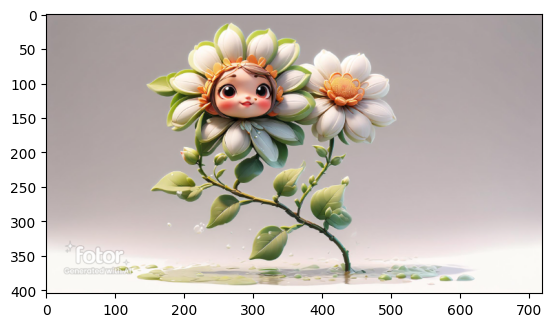

yellowish sunflower blue colour


  0%|          | 0/37 [00:00<?, ?it/s]

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
from diffusers import StableDiffusionImg2ImgPipeline
import torch

# Load the img2img pipeline
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-1", torch_dtype=torch.float16
).to("cuda")

# Function to preview the image
def preview_image(image_path):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.show()

# Function to generate image with prompt and limits
def generate_image(image_path, prompt, limits=None): # Set a default value for limits
    # Load and potentially crop/resize image based on 'limits'
    image = Image.open(image_path).convert("RGB").resize((512, 512))  # Replace with your desired size
    # Apply limits (cropping, masking, etc.) if needed
    # ... (You can add logic here to use 'limits' if provided)
    generated_image = pipe(
        prompt=prompt,
        image=image,
        strength=0.75,
        num_inference_steps=50,
    ).images[0]
    return generated_image

# Get image path from user
image_path = input("/content/sunflower p.png")

# Preview the image
preview_image(image_path)

# Get prompt from user
prompt = input("yellowish sunflower ")

# Get limits from user (e.g., bounding box coordinates) or leave it empty
# limits = ...  # You can add code here to get user input for limits

# Generate and save the image
generated_image = generate_image(image_path, prompt) # Call the function without limits or provide a value if you have defined it above
generated_image.save("generated_image.png")

In [ ]:
!pip install realesrgan